# Titanic Data Analysis

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.

We'll use a "semi-cleaned" version of the titanic data set.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="bright")

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [2]:
train = pd.read_csv("mk012-project_titanic_data_analysis/titanic_train.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

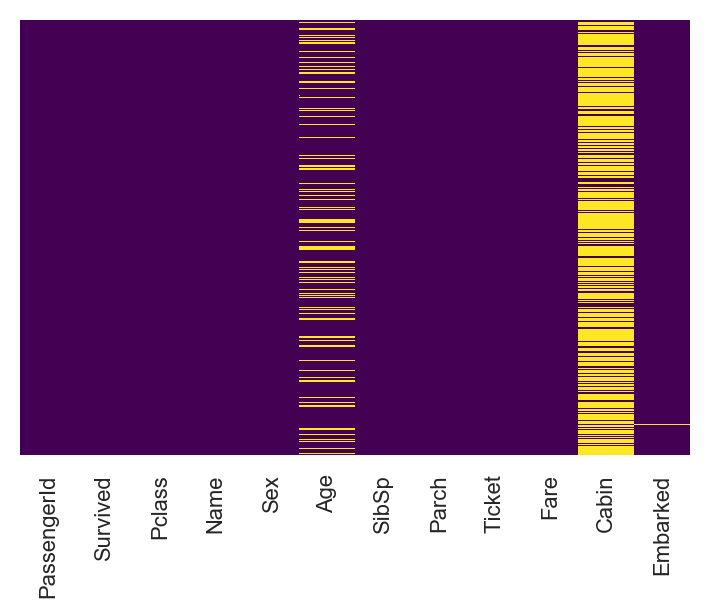

In [4]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data!

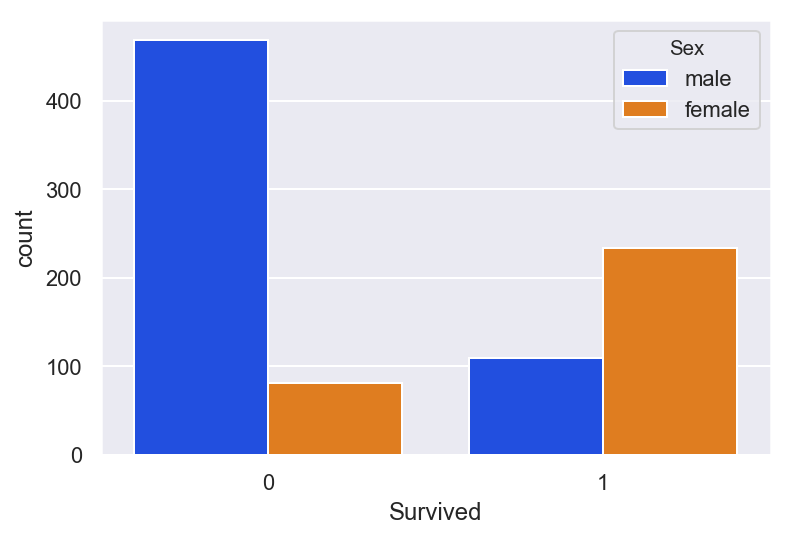

In [5]:
sns.countplot(x="Survived", hue="Sex", data=train)

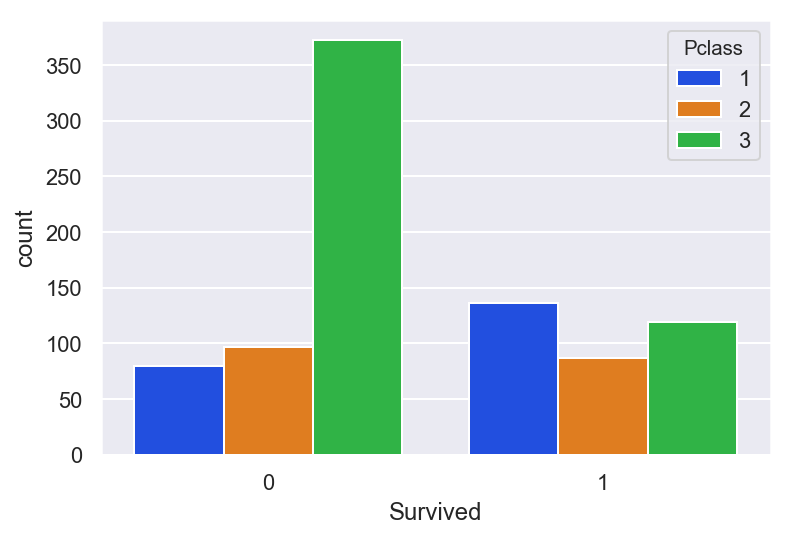

In [6]:
sns.countplot(x="Survived", hue="Pclass", data=train)

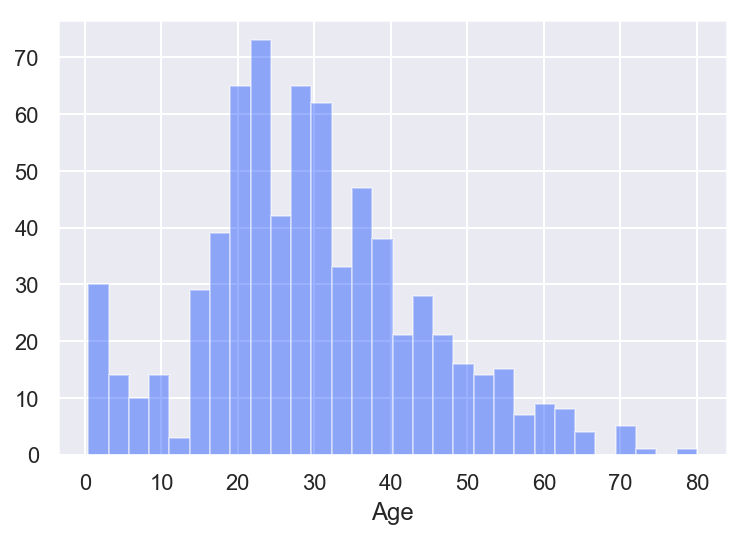

In [7]:
sns.distplot(train["Age"].dropna(), kde=False, bins=30)

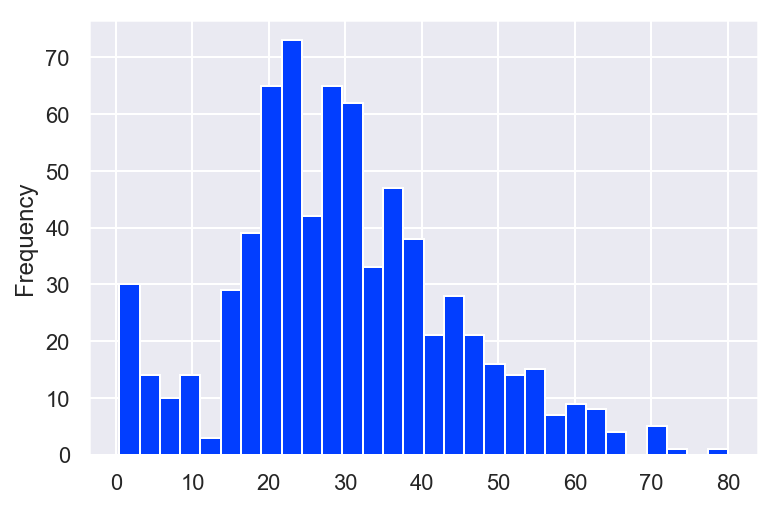

In [8]:
train["Age"].plot.hist(bins=30)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


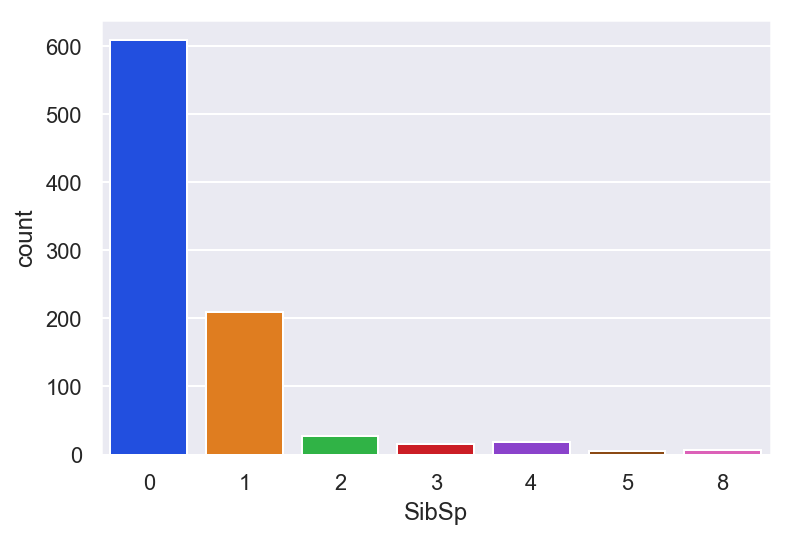

In [10]:
sns.countplot(x="SibSp", data=train)

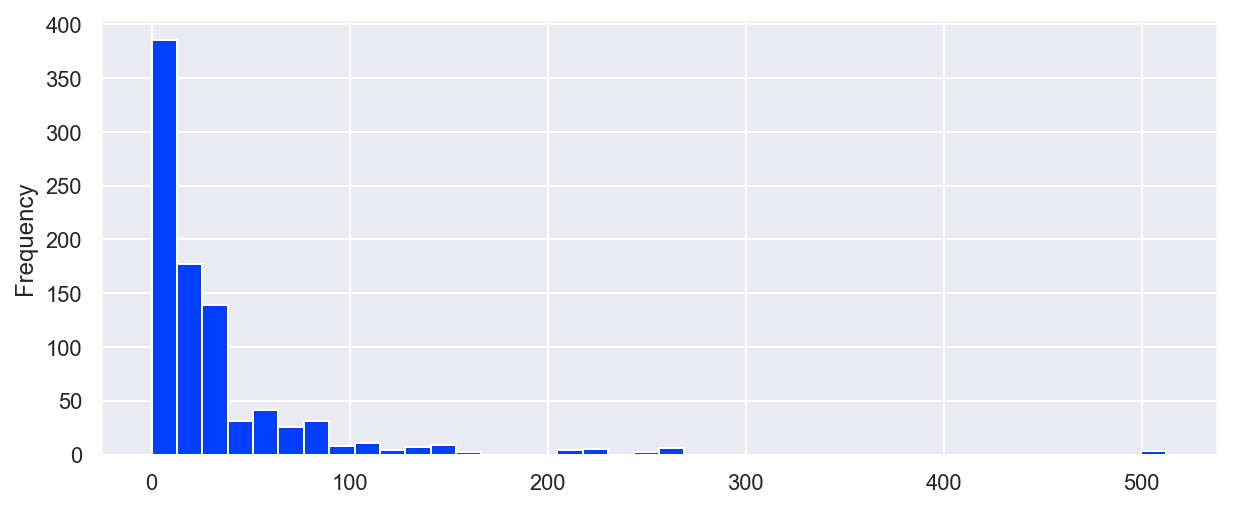

In [11]:
train["Fare"].plot.hist(bins=40, figsize=(10, 4))

### Cufflinks for plots

In [12]:
import cufflinks as cf
cf.go_offline()

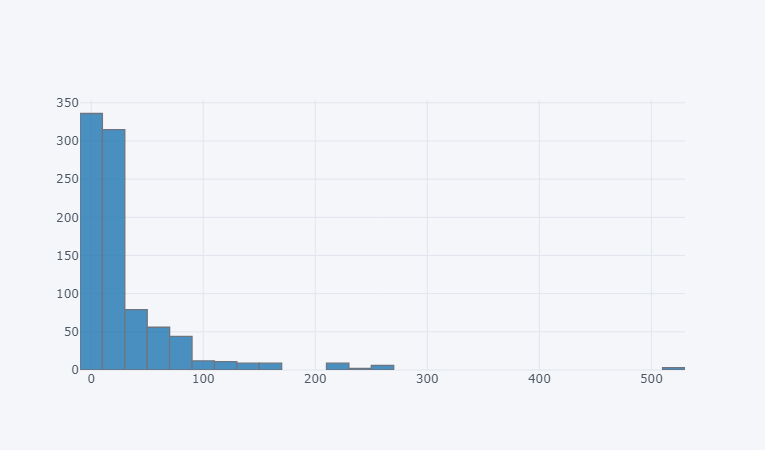

In [13]:
train["Fare"].iplot(kind="hist", bins=50)

## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


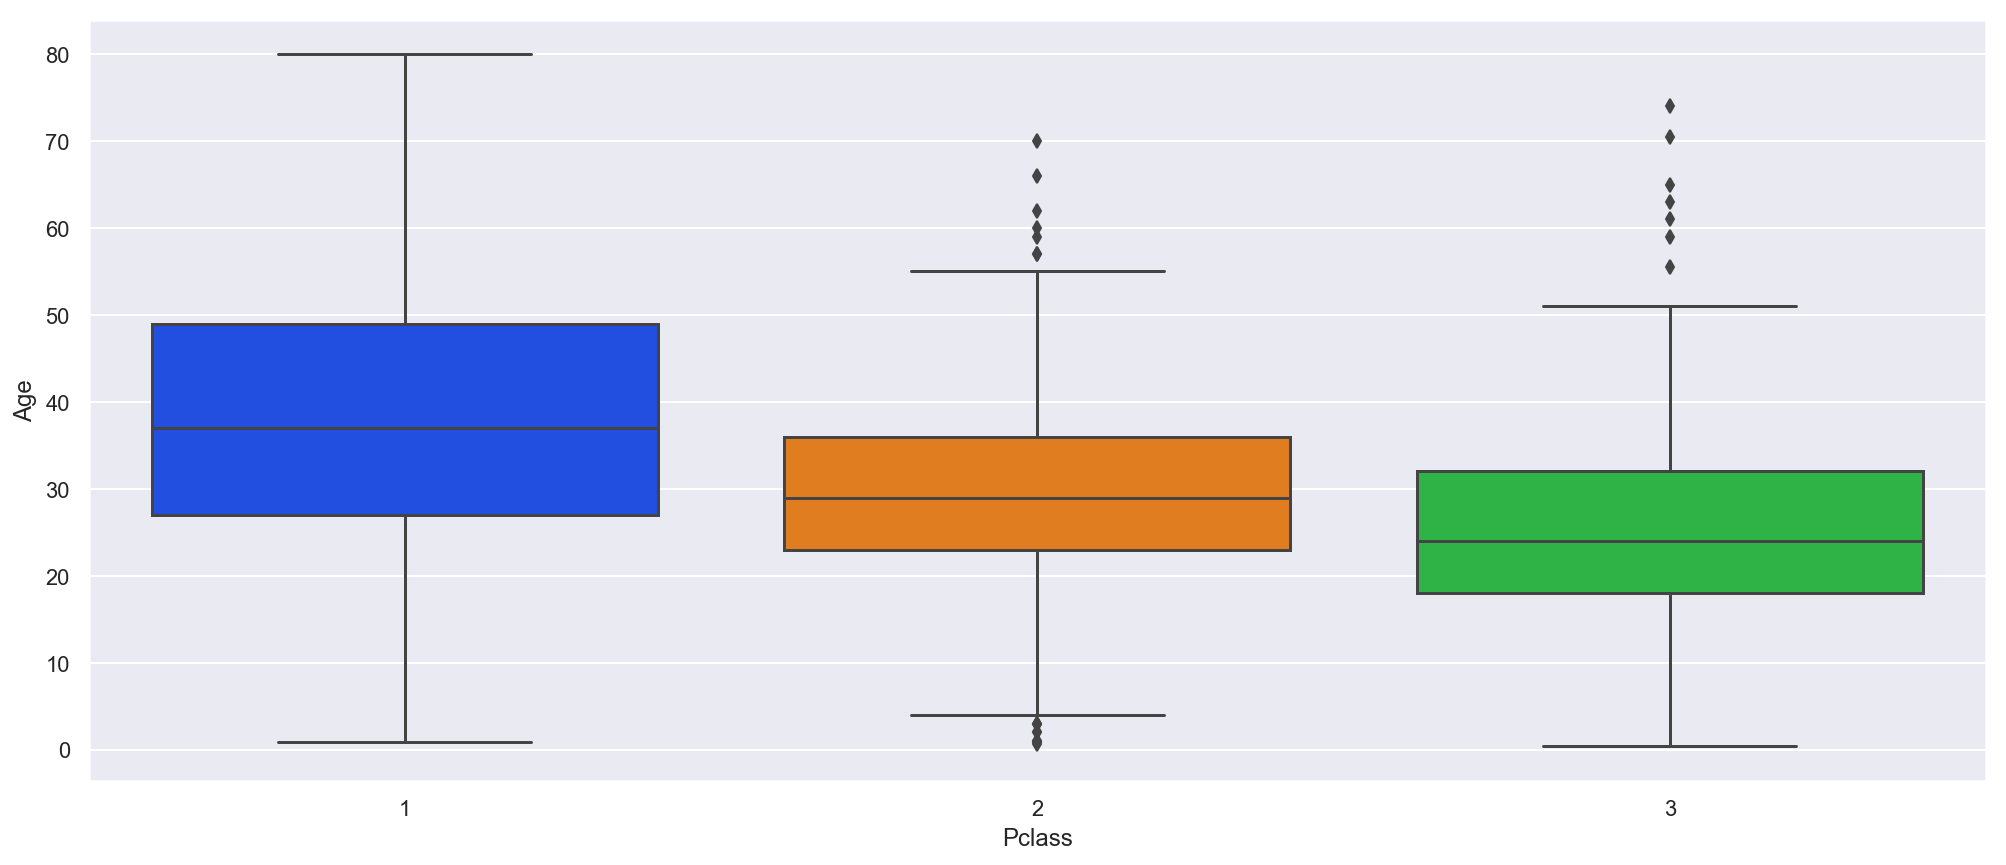

In [14]:
plt.figure(figsize=(17, 7))
sns.boxplot(x="Pclass", y="Age", data=train)

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [15]:
def impute_age(cols):
    
    Age = cols[0]
    Pclass = cols[1]
    
    mean_1 = train[train["Pclass"]==1]["Age"].mean()
    mean_2 = train[train["Pclass"]==2]["Age"].mean()
    mean_3 = train[train["Pclass"]==3]["Age"].mean()
    
    return mean_1 * Pclass==1 + mean_2 * Pclass==2 + mean_3 * Pclass==3 + Age

In [16]:
train["Age"] = train[["Age", "Pclass"]].apply(impute_age, axis=1)

Now let's check that heat map again!

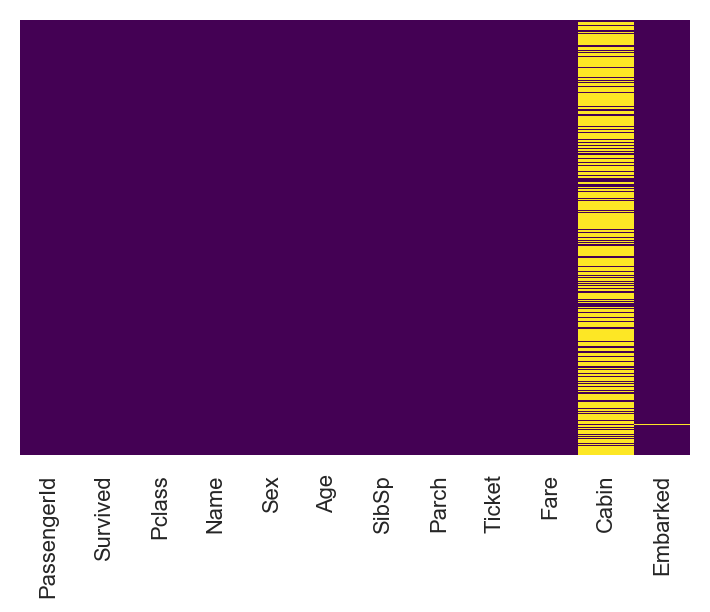

In [17]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [18]:
train.drop("Cabin", axis=1, inplace=True)

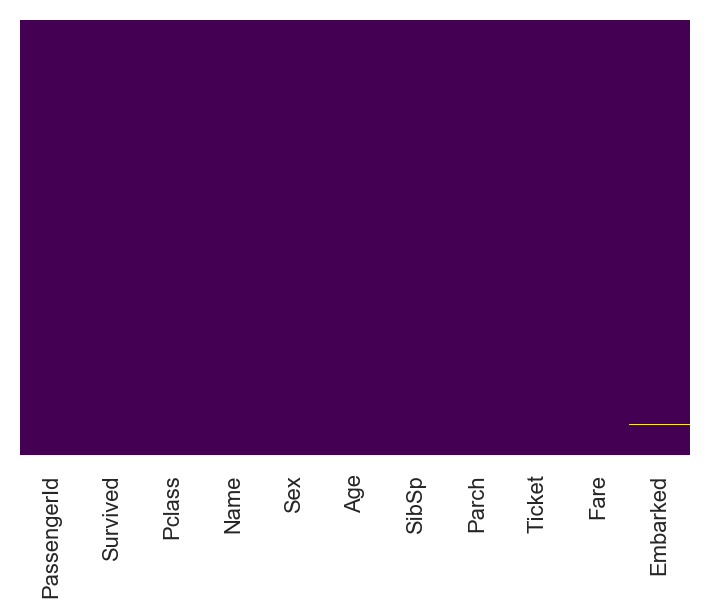

In [19]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [20]:
train.dropna(inplace=True)

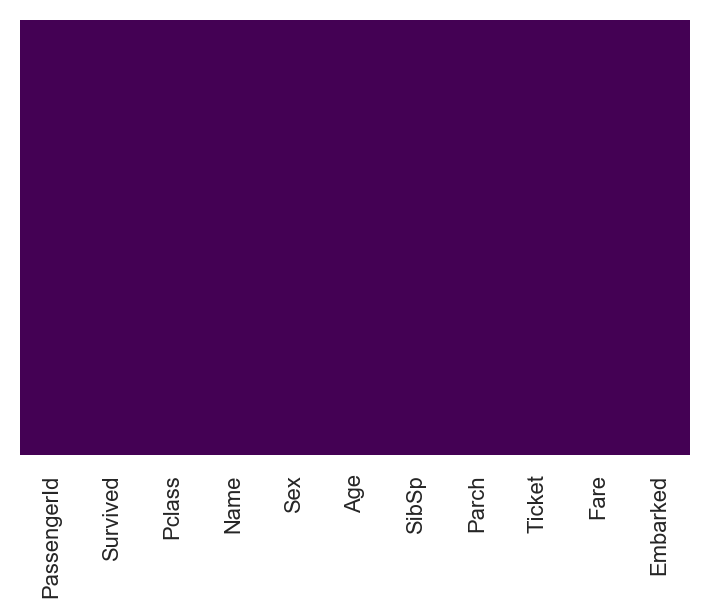

In [21]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [22]:
sex = pd.get_dummies(train["Sex"], drop_first=True)

In [23]:
embark = pd.get_dummies(train["Embarked"], drop_first=True)

In [24]:
train = pd.concat([train, sex, embark], axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,False,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,False,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,False,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,False,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,False,0,0,373450,8.0500,S,1,0,1


In [25]:
pclass = pd.get_dummies(train["Pclass"], drop_first=True)
pclass.columns = ['C2', 'C3']
pclass.head()

,C2,C3
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1


In [26]:
train = pd.concat([train, pclass], axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S,C2,C3
0,1,0,3,"Braund, Mr. Owen Harris",male,False,1,0,A/5 21171,7.2500,S,1,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,False,1,0,PC 17599,71.2833,C,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,False,0,0,STON/O2. 3101282,7.9250,S,0,0,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,False,1,0,113803,53.1000,S,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,False,0,0,373450,8.0500,S,1,0,1,0,1


In [27]:
train.drop(["Sex", "Embarked", "Name", "Ticket", "Pclass"], axis=1, inplace=True)
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,male,Q,S,C2,C3
0,1,0,False,1,0,7.2500,1,0,1,0,1
1,2,1,False,1,0,71.2833,0,0,0,0,0
2,3,1,False,0,0,7.9250,0,0,1,0,1
3,4,1,False,1,0,53.1000,0,0,1,0,0
4,5,0,False,0,0,8.0500,1,0,1,0,1


In [28]:
train.tail()

,PassengerId,Survived,Age,SibSp,Parch,Fare,male,Q,S,C2,C3
886,887,0,False,0,0,13.00,1,0,1,1,0
887,888,1,False,0,0,30.00,0,0,1,0,0
888,889,0,False,1,2,23.45,0,0,1,0,1
889,890,1,False,0,0,30.00,1,0,0,0,0
890,891,0,False,0,0,7.75,1,1,0,0,1


In [29]:
train.drop("PassengerId", axis=1, inplace=True)
train.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S,C2,C3
0,0,False,1,0,7.2500,1,0,1,0,1
1,1,False,1,0,71.2833,0,0,0,0,0
2,1,False,0,0,7.9250,0,0,1,0,1
3,1,False,1,0,53.1000,0,0,1,0,0
4,0,False,0,0,8.0500,1,0,1,0,1


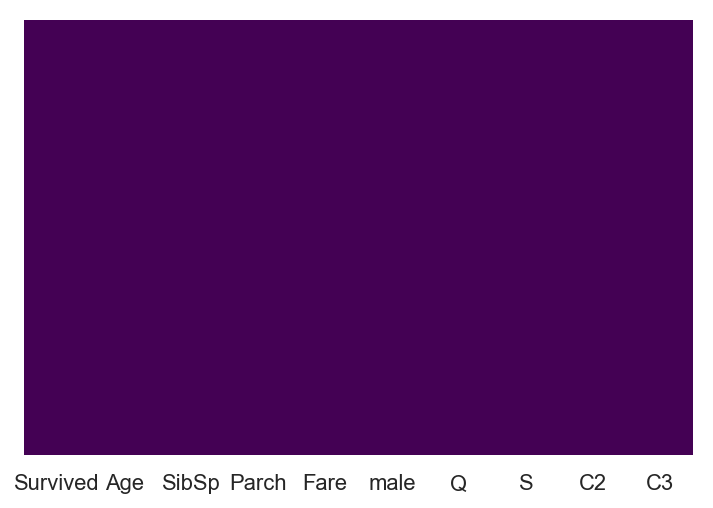

In [30]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X = train.drop("Survived", axis=1)
y = train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training and Predicting

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
logmodel = LogisticRegression(solver="lbfgs", max_iter=1000)

In [35]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
predictions = logmodel.predict(X_test)

## Evaluation
We can check precision, recall, f1-score using classification report!

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [38]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       163
           1       0.86      0.65      0.74       104

   micro avg       0.82      0.82      0.82       267
   macro avg       0.83      0.79      0.80       267
weighted avg       0.83      0.82      0.82       267

[[152  11]
 [ 36  68]]
